In [24]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [4]:
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = TextDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [5]:
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        preds = outputs.logits.argmax(dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [6]:
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            preds = outputs.logits.argmax(dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses), all_preds, all_labels

In [7]:
def train_model(train_data_loader, val_data_loader, model, optimizer, device, epochs):
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device)
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss, _, _ = eval_model(model, val_data_loader, device)
        print(f'Validation loss {val_loss} accuracy {val_acc}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

    return history

In [8]:
def preprocess(texts, tokenizer, max_len):
    encodings = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encodings

In [33]:
def predict(texts, model, tokenizer, max_len, device):
    model = model.eval()
    encodings = preprocess(texts, tokenizer, max_len)
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
    logits = outputs.logits
    preds = logits.argmax(dim=1).cpu().numpy()
    softmax_probs = torch.softmax(logits, dim=1).cpu().numpy()

    return preds, softmax_probs

In [21]:
def plot_history(history):
    train_acc = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in history['train_acc']]
    val_acc = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in history['val_acc']]
    train_loss = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in history['train_loss']]
    val_loss = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in history['val_loss']]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
MODEL_NAME = 'bert-base-multilingual-uncased'
MAX_LEN = 30
BATCH_SIZE = 512
EPOCHS = 3
LEARNING_RATE = 2e-5

In [12]:
# dir = '../Dataset Statistics/dataset'
dir = '/content/drive/MyDrive/Hate Speech_Multilingual /Code/Dataset Statistics/dataset'

train_df = pd.read_csv(f'{dir}/train.csv')
val_df = pd.read_csv(f'{dir}/val.csv')
test_df = pd.read_csv(f'{dir}/test.csv')

train_texts = train_df['english_text'].values
val_texts = val_df['english_text'].values
test_texts = test_df['english_text'].values

train_labels = train_df['class'].values
val_labels = val_df['class'].values
test_labels = test_df['class'].values

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_texts, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
history = train_model(train_data_loader, val_data_loader, model, optimizer, device, EPOCHS)

Epoch 1/3
----------
Train loss 0.10849030540893542 accuracy 0.9586137237154513
Validation loss 0.05925259266879555 accuracy 0.9766261725357528
Epoch 2/3
----------
Train loss 0.05527311548021866 accuracy 0.9775753282699093
Validation loss 0.05861523014626822 accuracy 0.9783753652160542
Epoch 3/3
----------
Train loss 0.04326870779806886 accuracy 0.9826256345677068
Validation loss 0.06225902963905908 accuracy 0.9783753652160542


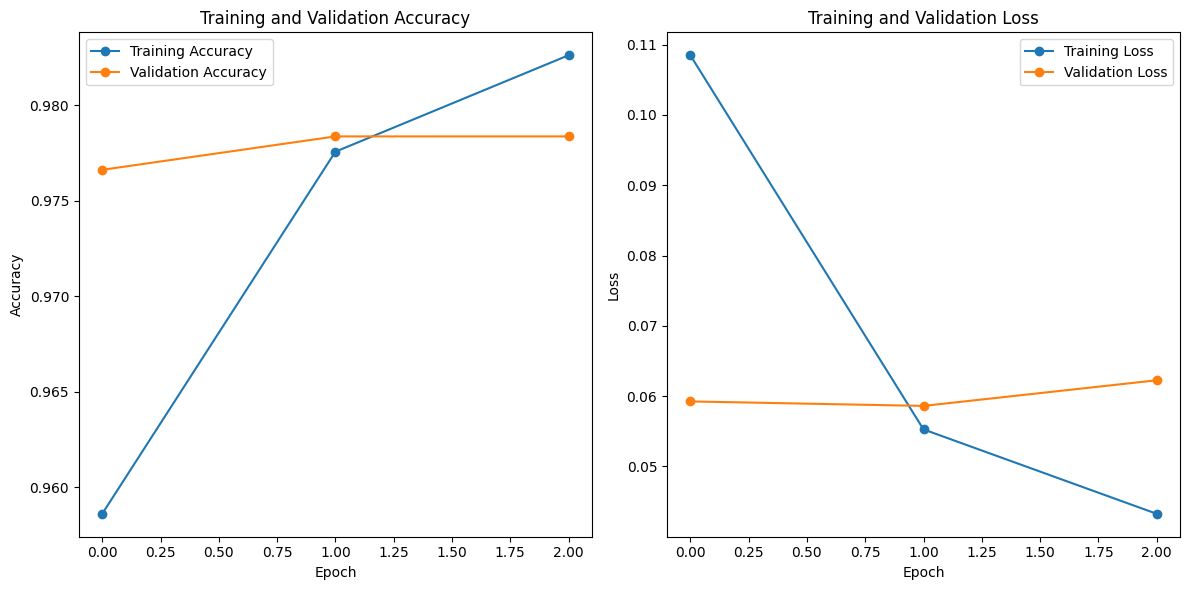

In [22]:
plot_history(history)

In [49]:
path = "/content/drive/MyDrive/Hate Speech_Multilingual /Code/Model training/saved_models/mBert_3_epochs"

tokenizer.save_pretrained(f'{path}/tokenizer')
model.save_pretrained(f'{path}/model')

In [23]:
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_acc, test_loss, test_label_actual, test_label_pred = eval_model(model, test_data_loader, device)
print(f'Test loss {test_loss} accuracy {test_acc}')

Test loss 0.05807512312905368 accuracy 0.9800522099198848


In [25]:
cm = confusion_matrix(test_label_actual, test_label_pred)
report = classification_report(test_label_actual, test_label_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     45729
           1       0.92      0.97      0.94      9816

    accuracy                           0.98     55545
   macro avg       0.96      0.97      0.97     55545
weighted avg       0.98      0.98      0.98     55545



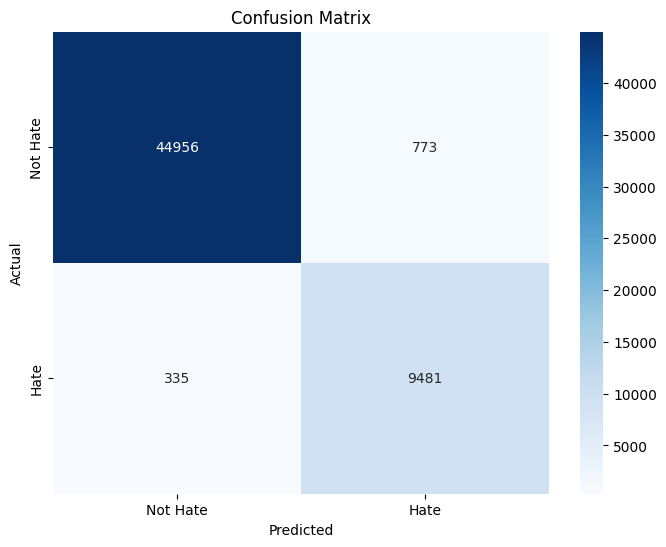

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hate', 'Hate'],
            yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [48]:
test_texts = ["This is the sort of thing that happens in a shithole country. @URL"]
preds, confidence = predict(test_texts, model, tokenizer, MAX_LEN, device)

if preds[0] == 1:
    print(f'Predicted class: Hate Speech \nConfidence: {confidence[0][1]:.2f}')
else:
    print(f'Predicted class: Not Hate Speech \nConfidence: {confidence[0][0]:.2f}')

Predicted class: Hate Speech 
Confidence: 0.87
